In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pprint import pprint

from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.decomposition import PCA

# --- Custom imports ---
from helpers import load_dataset_paths, compute_class_average_signal, summarize_results_and_save, load_vep_csv
from featex import FeatureExtractor
from dimred import DimensionalityReducer
import os
import re

In [2]:
# import scipy.signal as sp

# def bandpass_filter(signal, fs=2000, lowcut=1, highcut=30, order=4):
#     """
#     Apply zero-phase Butterworth band-pass filter to 1D signal.
#     fs      : sampling rate [Hz]
#     lowcut  : low cutoff frequency [Hz]
#     highcut : high cutoff frequency [Hz]
#     order   : filter order
#     """
#     nyq = 0.5 * fs
#     low = lowcut / nyq
#     high = highcut / nyq
#     b, a = sp.butter(order, [low, high], btype='band')
#     filtered = sp.filtfilt(b, a, signal)
#     return filtered

# def preprocess_signal(time, signal, t_min, t_max, normalize=True, baseline_window=(15, 25)):
#     mask = (time >= t_min) & (time <= t_max)
#     time_trimmed = time[mask]
#     signal_trimmed = signal[mask]

#     if normalize:
#         # Compute baseline mean and std in pre-stimulus window
#         base_mask = (time >= baseline_window[0]) & (time <= baseline_window[1])
#         baseline_mean = np.mean(signal[base_mask])
#         baseline_std = np.std(signal[base_mask])

#         # Baseline correction
#         signal_trimmed = signal_trimmed - baseline_mean

#         # Apply bandpass filter
#         signal_trimmed = bandpass_filter(signal_trimmed)

#         # Scale relative to baseline std, but guard against tiny values
#         if baseline_std > 1e-6:
#             signal_trimmed /= baseline_std

#         # Optional clipping to suppress spikes but preserve shape
#         signal_trimmed = np.clip(signal_trimmed, -5, 5)

#     return time_trimmed, signal_trimmed

# def load_vep_csv(file_path, t_min=10, t_max=125, normalize=True):
#     data = np.loadtxt(file_path, delimiter=",")
#     time = data[:, 0]
#     signal = data[:, 1]
#     time, signal = preprocess_signal(time, signal, t_min=t_min, t_max=t_max, normalize=normalize)
#     return time, signal

# def compute_class_average_signal(file_list, t_min=0, t_max=125, normalize=True):
#     """Compute the average signal across *all* files in a given class."""
#     all_times, all_signals = [], []

#     for file in tqdm(file_list, desc="Computing class average", leave=False):
#         time, signal = load_vep_csv(file, t_min=t_min, t_max=t_max, normalize=normalize)
#         all_times.append(time)
#         all_signals.append(signal)

#     # Find overlapping time region across all signals
#     common_t_min = max(t[0] for t in all_times)
#     common_t_max = min(t[-1] for t in all_times)
#     common_time = np.linspace(common_t_min, common_t_max, 1000)

#     interpolated_signals = [
#         np.interp(common_time, t, s) for t, s in zip(all_times, all_signals)
#     ]

#     avg_signal = np.mean(interpolated_signals, axis=0)
#     return common_time, avg_signal

## Analyze Noise

In [3]:
all_paths = load_dataset_paths()

# Example usage:
prima_files_BC_only = all_paths["PRIMA"]["BC_Only"]
prima_files_RGC_only = all_paths["PRIMA"]["RGC_Only"]
prima_files_BC_and_RGC = all_paths["PRIMA"]["BC_and_RGC"]

# print how many files are in each category
print(f"PRIMA BC_Only files: {len(prima_files_BC_only)}")
print(f"PRIMA RGC_Only files: {len(prima_files_RGC_only)}")
print(f"PRIMA BC_and_RGC files: {len(prima_files_BC_and_RGC)}")


PRIMA BC_Only files: 138
PRIMA RGC_Only files: 67
PRIMA BC_and_RGC files: 32


In [4]:
# --- Load the per-category summary tables ---
snr_summary_BC = pd.read_csv("Preprocessed_VEP_Data/PRIMA/BC_Only/SNR_summary_BC_Only.csv")
snr_summary_RGC = pd.read_csv("Preprocessed_VEP_Data/PRIMA/RGC_Only/SNR_summary_RGC_Only.csv")
snr_summary_BC_and_RGC = pd.read_csv("Preprocessed_VEP_Data/PRIMA/BC_and_RGC/SNR_summary_BC_and_RGC.csv")

# --- Compute SNR ratio ---
for df in [snr_summary_BC, snr_summary_RGC, snr_summary_BC_and_RGC]:
    df["SNR_Ratio"] = df["SNR_Signal"] / df["SNR_Noise"]
    df["FileName"] = df["FileName"].str.strip()

# --- Helper: IQR-based outlier removal ---
def filter_by_iqr(df, label):
    q1 = df["SNR_Ratio"].quantile(0.25)
    q3 = df["SNR_Ratio"].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    filtered = df[(df["SNR_Ratio"] >= lower) & (df["SNR_Ratio"] <= upper)].copy()
    n_removed = len(df) - len(filtered)

    mean_ratio = filtered["SNR_Ratio"].mean()
    std_ratio = filtered["SNR_Ratio"].std()

    print(f"[{label}] kept {len(filtered):3d}/{len(df):3d} files  "
          f"({len(filtered)/len(df)*100:5.1f}% kept, {n_removed} removed)  "
          f"→ mean SNR ratio = {mean_ratio:6.2f} ± {std_ratio:6.2f}")

    return filtered

# --- Apply filtering to each class ---
filtered_BC = filter_by_iqr(snr_summary_BC, "BC_Only")
filtered_RGC = filter_by_iqr(snr_summary_RGC, "RGC_Only")
filtered_BC_and_RGC = filter_by_iqr(snr_summary_BC_and_RGC, "BC_and_RGC")

# --- Map back to file paths using your original all_paths dict ---
def match_filtered_files(file_list, filtered_df, label):
    def normalize_name(name):
        """Normalize filename for consistent matching."""
        base = os.path.basename(str(name)).strip().lower()
        if not base.endswith(".csv"):
            base += ".csv"
        return base

    # Normalize both lists
    filtered_names = [normalize_name(n) for n in filtered_df["FileName"]]
    file_map = {normalize_name(f): f for f in file_list}

    matched = []
    skipped = []
    for name in filtered_names:
        if name in file_map:
            matched.append(file_map[name])
        else:
            skipped.append(name)

    print(f"[{label}] matched {len(matched)}/{len(filtered_names)} files ({len(skipped)} skipped)")
    if skipped:
        print("Skipped (not matched):", ", ".join(skipped[:8]), "..." if len(skipped) > 8 else "")

    return matched


prima_files_BC_only = match_filtered_files(prima_files_BC_only, filtered_BC, "BC_Only")
prima_files_RGC_only = match_filtered_files(prima_files_RGC_only, filtered_RGC, "RGC_Only")
prima_files_BC_and_RGC = match_filtered_files(prima_files_BC_and_RGC, filtered_BC_and_RGC, "BC_and_RGC")

print("\nAfter IQR filtering:")
print(f"  BC_Only:     {len(prima_files_BC_only)} files")
print(f"  RGC_Only:    {len(prima_files_RGC_only)} files")
print(f"  BC_and_RGC:  {len(prima_files_BC_and_RGC)} files")


[BC_Only] kept 125/137 files  ( 91.2% kept, 12 removed)  → mean SNR ratio =   2.05 ±   1.01
[RGC_Only] kept  60/ 66 files  ( 90.9% kept, 6 removed)  → mean SNR ratio =   1.62 ±   0.93
[BC_and_RGC] kept  29/ 31 files  ( 93.5% kept, 2 removed)  → mean SNR ratio =   5.28 ±   2.72
[BC_Only] matched 125/125 files (0 skipped)
[RGC_Only] matched 60/60 files (0 skipped)
[BC_and_RGC] matched 29/29 files (0 skipped)

After IQR filtering:
  BC_Only:     125 files
  RGC_Only:    60 files
  BC_and_RGC:  29 files


## Analyze Pulse Width + irradiance

In [5]:
def parse_filename(fname):
    """
    Handles patterns like:
    PRIMA100_9_10ms_0.60mWmm2.csv
    PRIMA100_7_1ms_1.53mWmm2_2.csv
    Pattern: Device_animal_pulsewidth_irradiance(_rep).csv
    """
    base = os.path.basename(fname)
    name = base[:-4] if base.lower().endswith(".csv") else base
    parts = name.split("_")

    # Remove trailing numeric repetition indicator (e.g. '_2')
    if parts[-1].isdigit():
        parts = parts[:-1]

    # Irradiance is now last
    irr_token = parts[-1]
    if not irr_token.endswith("mWmm2"):
        return None, None
    irr_str = irr_token.replace("mWmm2", "").replace("_", ".")
    try:
        irradiance = float(irr_str)
    except ValueError:
        return None, None

    # Pulse width is last token ending with 'ms'
    pulse_token = None
    for tok in reversed(parts[:-1]):
        if tok.endswith("ms"):
            pulse_token = tok[:-2]
            break
    if pulse_token is None:
        return None, None

    pulse_str = pulse_token.replace("_", ".")
    try:
        pulse_ms = float(pulse_str)
    except ValueError:
        return None, None

    return pulse_ms, irradiance


def make_table(file_list, label, out_dir="."):
    # Parse all files
    parsed = []
    unmatched = []
    for f in file_list:
        p, i = parse_filename(f)
        if p is None or i is None:
            unmatched.append(f)
        else:
            parsed.append((p, i))

    df = pd.DataFrame(parsed, columns=["pulse_width_ms", "irradiance_mWmm2"])

    # Crosstab (counts), sorted numerically by both axes
    # Convert to categorical with numeric sort to preserve order in crosstab
    if not df.empty:
        df["pulse_width_ms"] = pd.Categorical(df["pulse_width_ms"], 
                                              categories=sorted(df["pulse_width_ms"].unique()),
                                              ordered=True)
        df["irradiance_mWmm2"] = pd.Categorical(df["irradiance_mWmm2"],
                                                categories=sorted(df["irradiance_mWmm2"].unique()),
                                                ordered=True)
    table = pd.crosstab(df["irradiance_mWmm2"], df["pulse_width_ms"])

    # Add row totals
    table["Row_Total"] = table.sum(axis=1)

    # Add bottom total row (column sums)
    total_row = table.sum(axis=0)
    total_row.name = "Total"
    table = pd.concat([table, total_row.to_frame().T])

    # Save
    out_path = os.path.join(out_dir, f"PRIMA_{label}_summary.csv")
    table.to_csv(out_path, index=True)

    # Sanity prints (optional)
    parsed_n = len(parsed)
    print(f"[{label}] Parsed: {parsed_n} | Files provided: {len(file_list)} | Unmatched: {len(unmatched)}")
    if unmatched:
        print("Unmatched examples (first 10):")
        for u in unmatched[:10]:
            print("  -", os.path.basename(u))
    # Check that table entries sum to parsed files
    # (exclude the final 'Total' row when summing cell counts)
    cell_sum = table.iloc[:-1, :-1].to_numpy().sum()
    print(f"[{label}] Sum of cells (excluding totals): {cell_sum}")

    return table, out_path

# Build and save all three
BC_table, BC_path = make_table(prima_files_BC_only, "BC_Only")
RGC_table, RGC_path = make_table(prima_files_RGC_only, "RGC_Only")
BCRGC_table, BCRGC_path = make_table(prima_files_BC_and_RGC, "BC_and_RGC")

# print("Saved CSVs:")
# print(" -", BC_path)
# print(" -", RGC_path)
# print(" -", BCRGC_path)

# print filenames
for f in prima_files_BC_only:
    print(os.path.basename(f))

print("BC_Only table preview:")
print(BC_table.tail())

[BC_Only] Parsed: 125 | Files provided: 125 | Unmatched: 0
[BC_Only] Sum of cells (excluding totals): 125
[RGC_Only] Parsed: 60 | Files provided: 60 | Unmatched: 0
[RGC_Only] Sum of cells (excluding totals): 60
[BC_and_RGC] Parsed: 29 | Files provided: 29 | Unmatched: 0
[BC_and_RGC] Sum of cells (excluding totals): 29
PRIMA100_10_0_5ms_1.48mWmm2.csv
PRIMA100_10_0_5ms_2.22mWmm2.csv
PRIMA100_10_10ms_0.45mWmm2.csv
PRIMA100_10_1ms_1.02mWmm2.csv
PRIMA100_10_1ms_1.53mWmm2.csv
PRIMA100_10_3ms_0.68mWmm2.csv
PRIMA100_10_3ms_0.90mWmm2.csv
PRIMA100_10_5ms_0.63mWmm2.csv
PRIMA100_10_5ms_0.84mWmm2.csv
PRIMA100_11_0_5ms_1.48mWmm2.csv
PRIMA100_11_0_5ms_1.48mWmm2_2.csv
PRIMA100_11_0_5ms_2.22mWmm2.csv
PRIMA100_11_10ms_0.30mWmm2_2.csv
PRIMA100_11_10ms_0.45mWmm2.csv
PRIMA100_11_10ms_0.45mWmm2_2.csv
PRIMA100_11_10ms_0.60mWmm2.csv
PRIMA100_11_1ms_0.77mWmm2_2.csv
PRIMA100_11_1ms_1.02mWmm2.csv
PRIMA100_11_1ms_1.02mWmm2_2.csv
PRIMA100_11_1ms_1.53mWmm2.csv
PRIMA100_11_3ms_0.45mWmm2.csv
PRIMA100_11_3ms_0.45mWmm2


Plotting BC_Only...


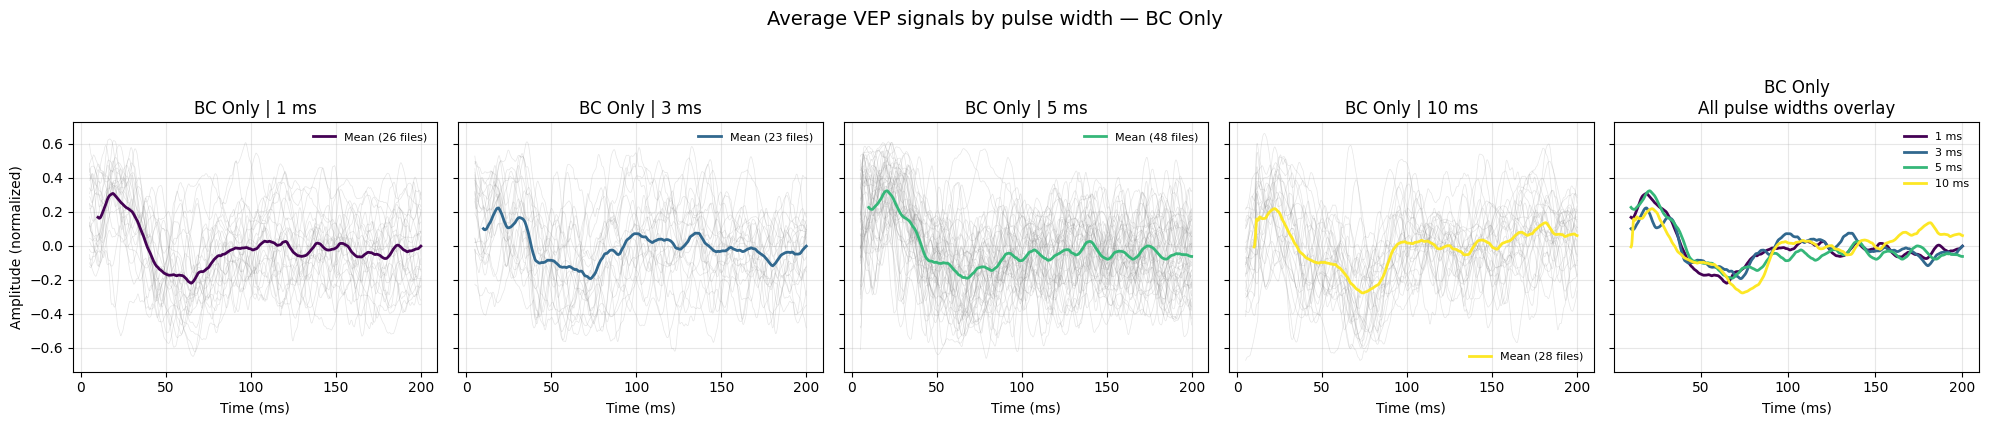


Plotting RGC_Only...


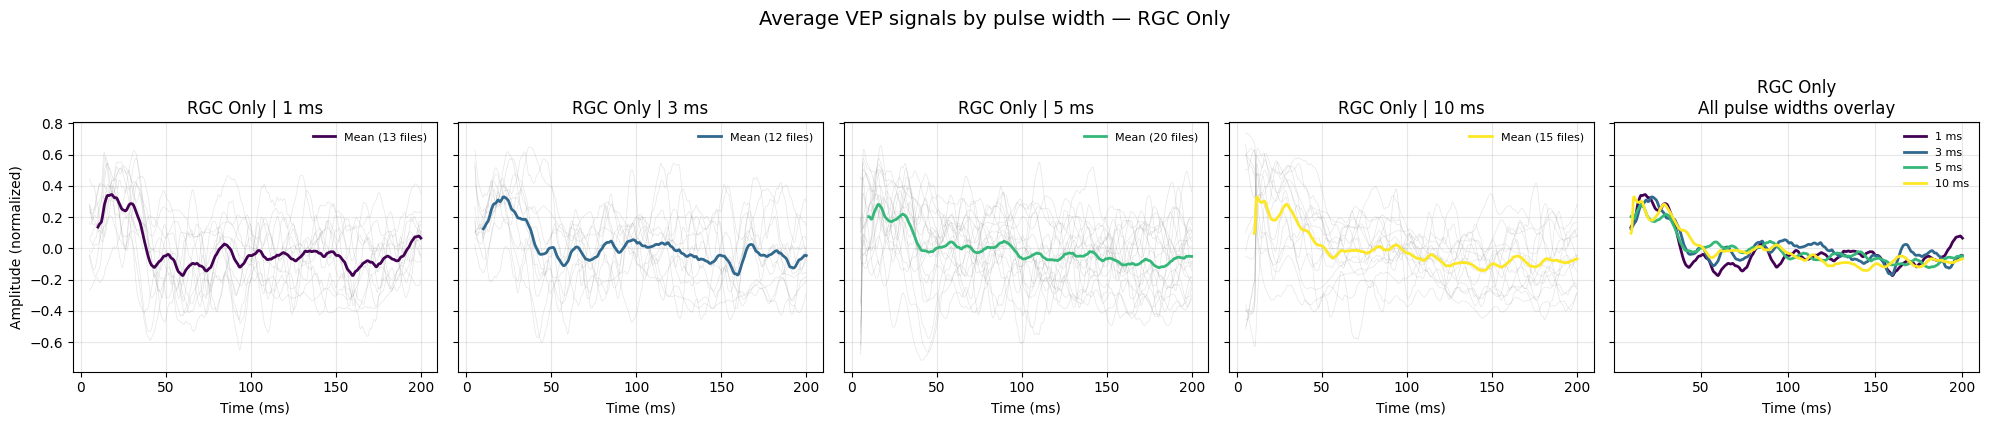


Plotting BC_and_RGC...


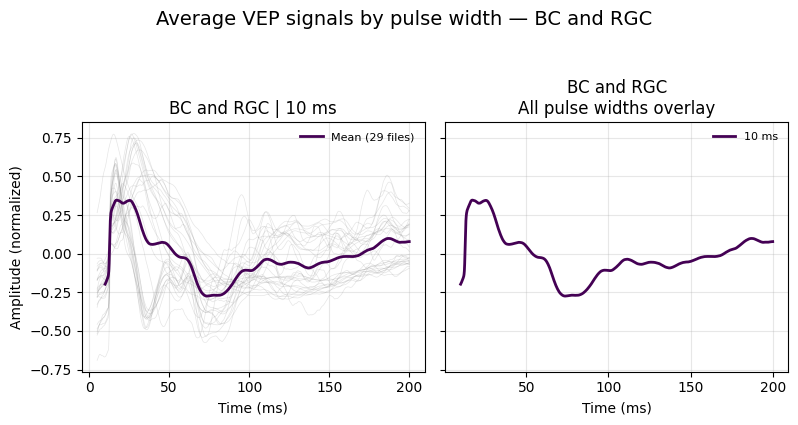

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_average_signals_by_pulsewidth(file_list, class_label):
    # --- Group by pulse width ---
    pulse_groups = {}
    for f in file_list:
        pulse, irr = parse_filename(f)
        if pulse is None:
            continue
        pulse_str = f"{pulse:.3f}".rstrip("0").rstrip(".")  # normalize key
        pulse_groups.setdefault(pulse_str, []).append(f)

    pulse_widths = sorted(pulse_groups.keys(), key=lambda x: float(x))
    n_pulses = len(pulse_widths)

    if n_pulses == 0:
        print(f"[{class_label}] No valid pulse widths found.")
        return

    # --- Create subplots: N pulse widths + 1 overlay ---
    fig, axes = plt.subplots(1, n_pulses + 1, figsize=(4*(n_pulses+1), 4), sharey=True)
    axes = np.atleast_1d(axes).flatten()  # <-- ensures iterable list

    average_signals = {}
    colors = plt.cm.viridis(np.linspace(0, 1, n_pulses))

    # --- Individual subplots ---
    for ax, pw, c in zip(axes[:-1], pulse_widths, colors):
        file_subset = pulse_groups[pw]

        # Compute average signal using your helper
        avg_t, avg_sig = compute_class_average_signal(file_subset, t_min=10, t_max=200, normalize=True)
        average_signals[pw] = (avg_t, avg_sig)

        # Plot individual signals
        for f in file_subset:
            t, sig = load_vep_csv(f, t_min=5, t_max=200, normalize=True)
            ax.plot(t, sig, alpha=0.2, lw=0.5, color="gray")

        # Plot average
        ax.plot(avg_t, avg_sig, color=c, lw=2, label=f"Mean ({len(file_subset)} files)")
        ax.set_title(f"{class_label} | {pw} ms")
        ax.set_xlabel("Time (ms)")
        ax.grid(alpha=0.3)
        if ax == axes[0]:
            ax.set_ylabel("Amplitude (normalized)")
        ax.legend(frameon=False, fontsize=8)

    # --- Overlay subplot ---
    overlay_ax = axes[-1]
    for pw, c in zip(pulse_widths, colors):
        avg_t, avg_sig = average_signals.get(pw, (None, None))
        if avg_t is not None:
            overlay_ax.plot(avg_t, avg_sig, lw=2, label=f"{pw} ms", color=c)
    overlay_ax.set_title(f"{class_label}\nAll pulse widths overlay")
    overlay_ax.set_xlabel("Time (ms)")
    overlay_ax.grid(alpha=0.3)
    overlay_ax.legend(frameon=False, fontsize=8)

    # --- Final layout ---
    plt.suptitle(f"Average VEP signals by pulse width — {class_label}", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()


# --- Run for each class ---
print("\nPlotting BC_Only...")
plot_average_signals_by_pulsewidth(prima_files_BC_only, "BC Only")

print("\nPlotting RGC_Only...")
plot_average_signals_by_pulsewidth(prima_files_RGC_only, "RGC Only")

print("\nPlotting BC_and_RGC...")
plot_average_signals_by_pulsewidth(prima_files_BC_and_RGC, "BC and RGC")


Plotting BC_Only (irradiance bins)...


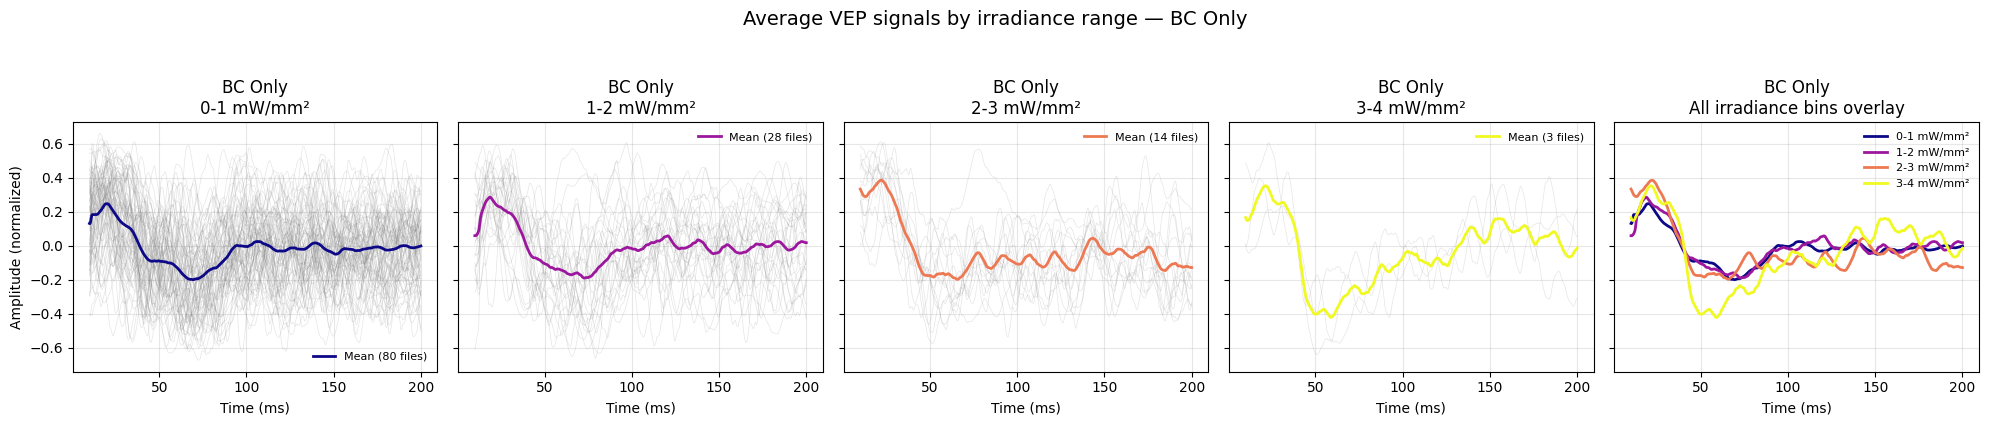


Plotting RGC_Only (irradiance bins)...


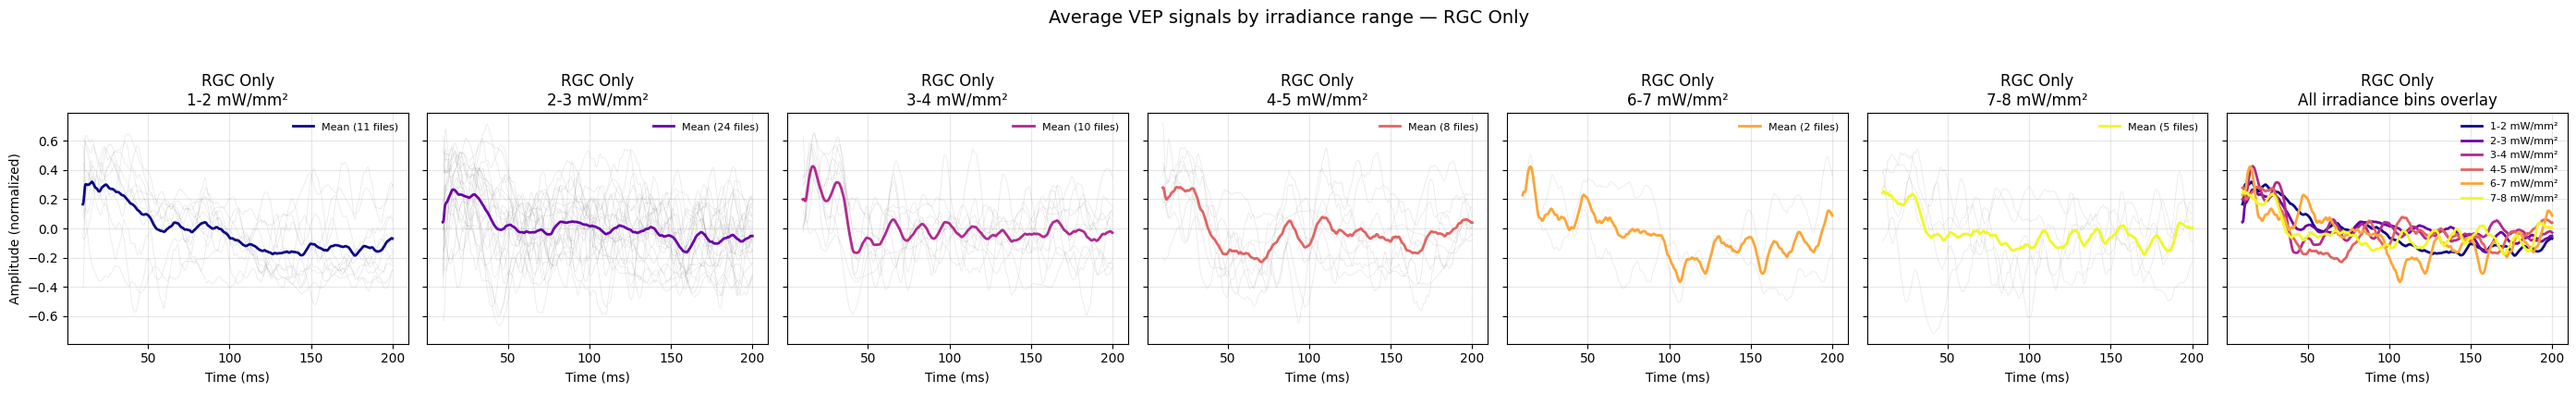


Plotting BC_and_RGC (irradiance bins)...


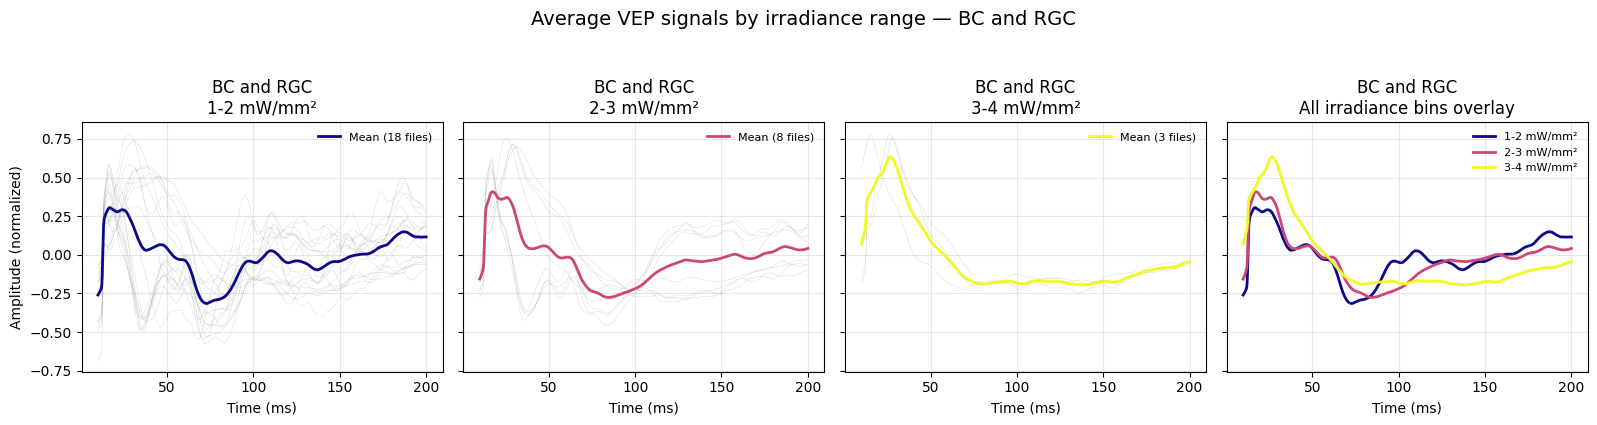

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# --- Plot average signal for each irradiance range per class ---
def plot_average_signals_by_irradiance_range(file_list, class_label, bin_size=1.0):
    """
    Groups files by irradiance range (e.g., 0-1, 1-2 mW/mm²)
    and plots the average signal for each bin + one overlay subplot.
    """
    # Parse irradiances and group by bins
    irr_groups = {}
    for f in file_list:
        pulse, irr = parse_filename(f)
        if irr is None:
            continue
        # Determine bin edges and label
        bin_floor = np.floor(irr / bin_size) * bin_size
        bin_ceil = bin_floor + bin_size
        bin_label = f"{bin_floor:.0f}-{bin_ceil:.0f} mW/mm²"
        irr_groups.setdefault(bin_label, []).append(f)

    bins_sorted = sorted(irr_groups.keys(), key=lambda b: float(b.split("-")[0]))
    n_bins = len(bins_sorted)
    if n_bins == 0:
        print(f"[{class_label}] No irradiance bins found.")
        return

    # --- Create subplots: N bins + 1 overlay ---
    fig, axes = plt.subplots(1, n_bins + 1, figsize=(4*(n_bins+1), 4), sharey=True)
    axes = np.atleast_1d(axes).flatten()

    average_signals = {}
    colors = plt.cm.plasma(np.linspace(0, 1, n_bins))

    # --- Individual irradiance-bin plots ---
    for ax, b, c in zip(axes[:-1], bins_sorted, colors):
        file_subset = irr_groups[b]
        avg_t, avg_sig = compute_class_average_signal(file_subset, t_min=10, t_max=200, normalize=True)
        average_signals[b] = (avg_t, avg_sig)

        # Plot individual signals faintly
        for f in file_subset:
            t, sig = load_vep_csv(f, t_min=10, t_max=200, normalize=True)
            ax.plot(t, sig, alpha=0.2, lw=0.5, color="gray")

        # Plot average
        ax.plot(avg_t, avg_sig, color=c, lw=2, label=f"Mean ({len(file_subset)} files)")
        ax.set_title(f"{class_label}\n{b}")
        ax.set_xlabel("Time (ms)")
        ax.grid(alpha=0.3)
        if ax == axes[0]:
            ax.set_ylabel("Amplitude (normalized)")
        ax.legend(frameon=False, fontsize=8)

    # --- Overlay subplot ---
    overlay_ax = axes[-1]
    for b, c in zip(bins_sorted, colors):
        avg_t, avg_sig = average_signals.get(b, (None, None))
        if avg_t is not None:
            overlay_ax.plot(avg_t, avg_sig, lw=2, label=b, color=c)
    overlay_ax.set_title(f"{class_label}\nAll irradiance bins overlay")
    overlay_ax.set_xlabel("Time (ms)")
    overlay_ax.grid(alpha=0.3)
    overlay_ax.legend(frameon=False, fontsize=8)

    # --- Final layout ---
    plt.suptitle(f"Average VEP signals by irradiance range — {class_label}", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()


# --- Run for each class ---
print("\nPlotting BC_Only (irradiance bins)...")
plot_average_signals_by_irradiance_range(prima_files_BC_only, "BC Only")

print("\nPlotting RGC_Only (irradiance bins)...")
plot_average_signals_by_irradiance_range(prima_files_RGC_only, "RGC Only")

print("\nPlotting BC_and_RGC (irradiance bins)...")
plot_average_signals_by_irradiance_range(prima_files_BC_and_RGC, "BC and RGC")
